In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import ta
import yfinance as yf

In [2]:
class StockPredictionAndAnomalyDetection:
    def __init__(self, time_steps=60):
        self.time_steps = time_steps
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.lstm_model = None
        self.autoencoder_model = None
        self.scaled_data = None

    def prepare_data(self, df):
        df['SMA_50'] = df['Close'].rolling(window=50).mean()
        df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
        df['RSI'] = ta.momentum.rsi(df['Close'], window=14)
        df['MACD'] = ta.trend.macd(df['Close'])
        df['Bollinger_High'] = ta.volatility.bollinger_hband(df['Close'])
        df['Bollinger_Low'] = ta.volatility.bollinger_lband(df['Close'])
        df['ATR'] = ta.volatility.average_true_range(df['High'], df['Low'], df['Close'])
        df['Stochastic'] = ta.momentum.stoch(df['High'], df['Low'], df['Close'])
        df['OBV'] = ta.volume.on_balance_volume(df['Close'], df['Volume'])
        df['Volume_Change'] = df['Volume'].pct_change()
        df['Price_Change'] = df['Close'].pct_change()
        df.fillna(method='bfill', inplace=True)
        self.scaled_data = self.scaler.fit_transform(df[['Close', 'SMA_50', 'EMA_20', 'RSI', 'MACD', 'Bollinger_High', 'Bollinger_Low', 'ATR', 'Stochastic', 'OBV', 'Volume_Change', 'Price_Change']])
        return df

    def create_lstm_data(self):
        X, y = [], []
        for i in range(self.time_steps, len(self.scaled_data)):
            X.append(self.scaled_data[i-self.time_steps:i])
            y.append(self.scaled_data[i, 0])  # Close price as the target
        return np.array(X), np.array(y)

    def build_lstm_model(self):
        model = Sequential([
            LSTM(units=50, return_sequences=True, input_shape=(self.time_steps, self.scaled_data.shape[1])),
            Dropout(0.2),
            LSTM(units=50, return_sequences=False),
            Dropout(0.2),
            Dense(units=1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    def build_autoencoder_model(self):
        model = Sequential([
            LSTM(128, input_shape=(self.time_steps, self.scaled_data.shape[1]), return_sequences=True),
            Dropout(0.2),
            LSTM(64, return_sequences=False),
            Dropout(0.2),
            RepeatVector(self.time_steps),
            LSTM(64, return_sequences=True),
            Dropout(0.2),
            LSTM(128, return_sequences=True),
            Dropout(0.2),
            TimeDistributed(Dense(self.scaled_data.shape[1]))
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    def train_lstm_model(self, X_train, y_train, X_val, y_val):
        lstm_checkpoint = ModelCheckpoint('combined_lstm_model.keras', save_best_only=True, monitor='val_loss', mode='min')
        lstm_early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = self.lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[lstm_checkpoint, lstm_early_stop])
        self.lstm_model = load_model('combined_lstm_model.keras')
        return history

    def train_autoencoder_model(self, X_train, X_val):
        autoencoder_checkpoint = ModelCheckpoint('autoencoder_model.keras', save_best_only=True, monitor='val_loss', mode='min')
        autoencoder_early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = self.autoencoder_model.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val), callbacks=[autoencoder_checkpoint, autoencoder_early_stop])
        self.autoencoder_model = load_model('autoencoder_model.keras')
        return history

    def train_combined_model(self, df):
        df = self.prepare_data(df)
        X, y = self.create_lstm_data()
        X_train, X_val, y_train, y_val = X[:-200], X[-200:], y[:-200], y[-200:]
        self.lstm_model = self.build_lstm_model()
        self.autoencoder_model = self.build_autoencoder_model()
        self.train_lstm_model(X_train, y_train, X_val, y_val)
        self.train_autoencoder_model(X_train, X_val)
        predicted_prices = self.lstm_model.predict(X_val)
        predicted_prices = self.scaler.inverse_transform(np.concatenate([predicted_prices, np.zeros((predicted_prices.shape[0], self.scaled_data.shape[1] - 1))], axis=1))[:, 0]
        actual_prices = self.scaler.inverse_transform(np.concatenate([y_val.reshape(-1, 1), np.zeros((y_val.shape[0], self.scaled_data.shape[1] - 1))], axis=1))[:, 0]
        residuals = actual_prices - predicted_prices

        # Calculate reconstruction errors
        reconstructions = self.autoencoder_model.predict(X_val)
        reconstruction_errors = np.mean(np.abs(reconstructions - X_val), axis=1)

        # Calculate accuracy
        direction_actual = np.diff(actual_prices) > 0
        direction_predicted = np.diff(predicted_prices) > 0
        accuracy = accuracy_score(direction_actual, direction_predicted)
        
        # Plotting actual vs. predicted prices
        plt.figure(figsize=(14, 7))
        plt.plot(actual_prices, color='blue', label='Actual Prices')
        plt.plot(predicted_prices, color='red', label='Predicted Prices')
        plt.title('Actual vs. Predicted Stock Prices')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

        return mean_squared_error(actual_prices, predicted_prices, squared=False), accuracy, reconstruction_errors

    def predict_next_7_days(self):
        last_60_days = self.scaled_data[-self.time_steps:]
        temp_input = list(last_60_days)  # Initialize with the last 60 days of scaled data
        temp_input = [list(item) for item in temp_input]  # Ensure each element is a list
        lst_output = []

        for i in range(7):
            if len(temp_input) > self.time_steps:
                temp_input = temp_input[1:]  # Maintain the sliding window of size self.time_steps
            x_input = np.array(temp_input).reshape((1, self.time_steps, self.scaled_data.shape[1]))
            yhat = self.lstm_model.predict(x_input, verbose=0)
            next_input = [list(yhat[0])]
            temp_input.append(next_input)
            lst_output.append(yhat[0])

        return self.scaler.inverse_transform(np.concatenate([np.array(lst_output), np.zeros((len(lst_output), self.scaled_data.shape[1] - 1))], axis=1))[:, 0]

    def detect_anomalies(self, df):
        df = self.prepare_data(df)
        X, y = self.create_lstm_data()
        predicted_prices = self.lstm_model.predict(X)
        predicted_prices = self.scaler.inverse_transform(np.concatenate([predicted_prices, np.zeros((predicted_prices.shape[0], self.scaled_data.shape[1] - 1))], axis=1))[:, 0]
        actual_prices = self.scaler.inverse_transform(np.concatenate([y.reshape(-1, 1), np.zeros((y.shape[0], self.scaled_data.shape[1] - 1))], axis=1))[:, 0]
        residuals = actual_prices - predicted_prices

        # Reconstruction errors
        reconstructions = self.autoencoder_model.predict(X)
        reconstruction_errors = np.mean(np.abs(reconstructions - X), axis=1)
        threshold = np.percentile(reconstruction_errors, 95)
        anomalies = reconstruction_errors > threshold
        manipulation_percentage = np.sum(anomalies) / len(anomalies) * 100

        # Plotting actual vs. predicted prices with anomalies
        plt.figure(figsize=(14, 7))
        plt.plot(actual_prices, color='blue', label='Actual Prices')
        plt.plot(predicted_prices, color='red', label='Predicted Prices')
        plt.scatter(np.where(anomalies)[0], actual_prices[anomalies], color='green', label='Anomalies')
        plt.title('Actual vs. Predicted Stock Prices with Anomalies')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

        return actual_prices, predicted_prices, anomalies, manipulation_percentage

In [3]:
# Existing code for data fetching
ticker = 'GME'
stockPrices = yf.download(ticker, '1981-01-01', '2024-07-22')

[*********************100%%**********************]  1 of 1 completed


In [4]:
stockPrices.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-02-13,2.40625,2.51500,2.38125,2.51250,1.691666,76216000
2002-02-14,2.54375,2.54875,2.48125,2.50000,1.683251,11021600
2002-02-15,2.50000,2.50625,2.46250,2.48750,1.674834,8389600
2002-02-19,2.47500,2.47500,2.34375,2.38750,1.607504,7410400
2002-02-20,2.40000,2.46875,2.38125,2.46875,1.662210,6892800


In [5]:
stockPrices.isnull()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-02-13,False,False,False,False,False,False
2002-02-14,False,False,False,False,False,False
2002-02-15,False,False,False,False,False,False
2002-02-19,False,False,False,False,False,False
2002-02-20,False,False,False,False,False,False
...,...,...,...,...,...,...
2024-07-15,False,False,False,False,False,False
2024-07-16,False,False,False,False,False,False
2024-07-17,False,False,False,False,False,False


In [6]:
stockPrices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5646 entries, 2002-02-13 to 2024-07-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5646 non-null   float64
 1   High       5646 non-null   float64
 2   Low        5646 non-null   float64
 3   Close      5646 non-null   float64
 4   Adj Close  5646 non-null   float64
 5   Volume     5646 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 308.8 KB


In [7]:
stockPrices.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [8]:
stockPrices.shape

(5646, 6)

In [9]:
stockPrices.size

33876

In [10]:
stockPrices.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5646.000000,5646.000000,5646.000000,5646.000000,5646.000000,5.646000e+03
mean,9.371573,9.688580,9.058711,9.352457,8.018803,1.453100e+07
std,10.389287,11.038386,9.748765,10.295986,10.540438,2.981795e+07
min,0.712500,0.735000,0.642500,0.700000,0.638793,2.600000e+05
25%,3.670625,3.745000,3.600625,3.675000,2.920049,5.394800e+06
50%,5.972500,6.055000,5.866250,5.971250,4.234187,9.626400e+06
75%,10.551875,10.743125,10.382500,10.567500,7.641418,1.518860e+07
max,94.927498,120.750000,72.877502,86.877502,86.877502,7.886316e+08


In [11]:
# Clean the column names
stockPrices.columns = stockPrices.columns.str.strip()

In [12]:
stockPrices.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-02-13,2.40625,2.51500,2.38125,2.51250,1.691666,76216000
2002-02-14,2.54375,2.54875,2.48125,2.50000,1.683251,11021600
2002-02-15,2.50000,2.50625,2.46250,2.48750,1.674834,8389600
2002-02-19,2.47500,2.47500,2.34375,2.38750,1.607504,7410400
2002-02-20,2.40000,2.46875,2.38125,2.46875,1.662210,6892800


C:\Users\Loricson\AppData\Local\Temp\ipykernel_36048\2369997276.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
c:\Users\Loricson\anaconda3\envs\fyp-gpu\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0047 - val_loss: 0.0019
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 8.8882e-04 - val_loss: 0.0016
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 7.8539e-04 - val_loss: 0.0015
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 8.3382e-04 - val_loss: 0.0015
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 6.1492e-04 - val_loss: 0.0015
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 7.4113e-04 - val_loss: 0.0017
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 7.0729e-04 - val_loss: 0.0014
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 5.8952e-04 - val_loss: 0.0013
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 8.1527e-04 - val_loss: 0.0013
Epoch 12/

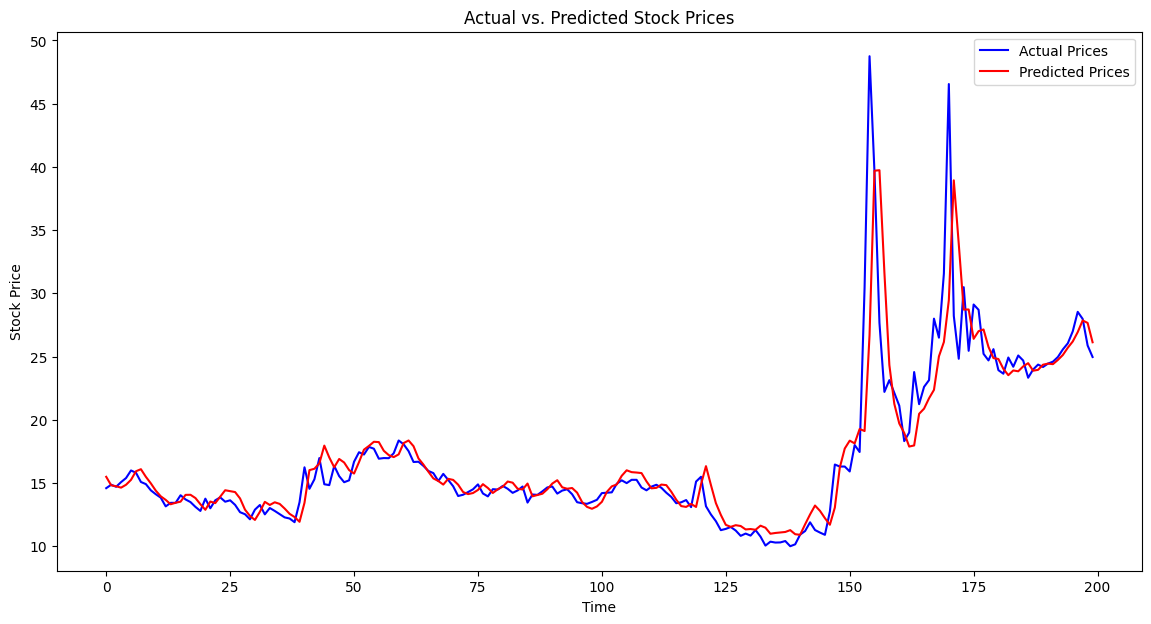

c:\Users\Loricson\anaconda3\envs\fyp-gpu\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (60,) + inhomogeneous part.

In [13]:
model = StockPredictionAndAnomalyDetection()
rmse, accuracy, reconstruction_errors = model.train_combined_model(stockPrices)
next_7_days_prediction = model.predict_next_7_days()
actual_prices, predicted_prices, anomalies, manipulation_percentage = model.detect_anomalies(stockPrices)

In [ ]:
print(f"RMSE: {rmse}")
print(f"Accuracy: {accuracy}")
print(f"Next 7 days prediction: {next_7_days_prediction}")
print(f"Percentage of data points marked as anomalies (possible manipulation): {manipulation_percentage:.2f}%")